In [1]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
granularity = 10

if granularity == 50:

    PATH = 'results_50'

    df = pd.read_csv("db_extract/df_indi_works_occupations.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 50 * round(x / 50))
    df = df[df['decade']<=1850]

elif granularity == 10:

    PATH = 'results_10'

    df = pd.read_csv("db_extract/df_indi_works_occupations.csv", index_col=0)
    df['decade'] = df['decade'].apply(lambda x: 10 * round(x / 10))
    df = df[df['decade']<=1880]

In [3]:
df_work_3 = df[df['count_works']>2]
df_work_3 = df_work_3.drop('occupation', axis=1).drop_duplicates()
df_work_3.region_name.value_counts()

region_name
Western Europe         15848
Northwestern Europe    12950
France                  3599
British Islands         3041
United Kingdom          2947
Southwestern Europe     2880
German world            2872
Northern France         2705
Low countries           2512
Germany                 2193
Italy                   2074
Northern Italy          1689
Netherlands             1615
Eastern Europe          1398
North America           1138
Nordic countries         933
Belgium                  896
Central Europe           781
Southern France          755
Spain                    695
Chinese world            519
Sweden                   498
Austria                  489
East Slavic              480
Southern Italy           320
Muslim world             299
Denmark                  283
Arabic world             240
Japan                    233
mediterranean World      223
Southern China           216
Switzerland              193
Yangtze                  160
Northern China           145
So

In [4]:
len(set(df.individual_wikidata_id))

139206

In [5]:
regions = pd.read_csv(
    "other_data/ENS - Cultural Index - Countries Databases - region_level.csv"
)
regions["region_name"][regions["region_name"] == "Slav world"] = "East Slavic"
regions = regions[regions["level"] == 2]
regions = regions[regions["region_name"] != "Balkans"]
regions = regions[
    regions["region_name"] != "Eastern Europe"
]  # remove because it takes East Slavic and Central Europe
regions = set(regions["region_name"])

north_south_regions = ['Southern China', 'Northern China'] + ['Northwestern Europe', 'Southwestern Europe'] + ['Northern Japan', 'Southern Japan']

all_regions = list(regions) + north_south_regions

#df = df[df["region_name"].isin(regions)]
df = df[df["region_name"].isin(all_regions)]

df["century"] = df["decade"].round(-2)
# Avoid overlapping with Antiquity

df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Portugal") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Spain") & (df["decade"] < 500))]
# df = df[~((df["region_name"] == "Arabic world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Balkans") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "France") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "United Kingdom") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Low countries") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "East Slavic") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Central Europe") & (df["decade"] < 500))]
#df = df[~((df["region_name"] == "Eastern Europe") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "German world") & (df["decade"] < 500))]
df = df[~((df["region_name"] == "Latin world") & (df["decade"] > 500))]


print(len(set(df.individual_wikidata_id)))

127707


In [6]:
df["count"] = df["count_works"]
df_m = df.copy()
df_m = df_m[df_m["count"].isin({0, 1, 2})]  # Not more ?
df_m["y"] = df_m["count"].map({0: 0, 1: 0, 2: 1})

In [7]:
len(set(df_m.individual_wikidata_id))

109363

In [8]:
df_distribution = df_m[['individual_wikidata_id','occupation']].drop_duplicates()
df_distribution.occupation.value_counts()

occupation
Writer               53007
Painter              23878
Musician             14757
Architect             7539
Sculptor              6953
Performing Artist     3229
Name: count, dtype: int64

In [9]:
df_count_work_model = df_m.copy()
df_count_work_model['count_works'][df_count_work_model['count_works']==0] = 1
df_count_work_model = df_count_work_model.groupby(['region_name'])['count_works'].sum().reset_index()
df_count_work_model = df_count_work_model.rename(columns = {'count_works':'count_works_f1_f2'})

In [10]:
# knots
num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)
iknots = knots[1:-1]

sample = df_m.copy()
#sample = sample.sample(20000, random_state=42)

In [11]:
print(len(set(sample.individual_wikidata_id)))

109363


In [12]:
sample.region_name.value_counts()

region_name
Northwestern Europe    71086
German world           29339
Southwestern Europe    20237
France                 17841
Italy                  14225
United Kingdom         10689
Central Europe          8500
Low countries           7233
Nordic countries        5414
Spain                   5026
East Slavic             3919
Chinese world           1504
Arabic world            1202
Greek World             1103
Japan                    949
Portugal                 718
Persian world            475
Indian world             412
Southern China           320
Latin World              294
Southern Japan           235
Northern China           188
Korea                    179
Northern Japan           155
Name: count, dtype: int64

In [13]:
#MODEL 3
equation = 'y ~ bs(decade, knots=iknots, intercept=True) + occupation +(1|region_name)'
# SECOND MODEL
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    equation, 
    sample, 
    family='bernoulli', 
    priors=priors)


base_model_fitted = base_model.fit(
    draws=1000,
    chains=4,
    inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},
)  # important to run faster and sample more efficiently


Modeling the probability that y==1
Compiling...
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:03.272705
Sampling...
sample: 100%|██████████| 2000/2000 [06:46<00:00,  4.92it/s, 511 steps of size 2.11e-02. acc. prob=0.92] 
Sampling time = 0:27:33.777421
Transforming variables...
Transformation time = 0:00:00.273192
Computing Log Likelihood...
2024-10-03 18:49:26.923276: W external/xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 4.25GiB (4558206643 bytes) by rematerialization; only reduced to 6.00GiB (6439776000 bytes), down from 6.00GiB (6439776000 by

In [14]:
# import pickle

# # Save the fitted model to a file
# with open('base_model_fitted_north_south.pkl', 'wb') as file:
#     pickle.dump(base_model_fitted, file)


# import pickle


# # Load the fitted model from a file
# with open('base_model_fitted_north_south.pkl', 'rb') as file:
#     base_model_fitted = pickle.load(file)

In [15]:
az.summary(base_model_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.01,1.48,-5.90,-0.32,0.06,0.04,604.00,873.00,1.01
"bs(decade, knots=iknots, intercept=True)[0]",1.77,2.25,-2.53,5.86,0.07,0.05,1201.00,1908.00,1.00
"bs(decade, knots=iknots, intercept=True)[1]",-0.07,1.98,-3.59,3.75,0.06,0.04,1014.00,1844.00,1.01
"bs(decade, knots=iknots, intercept=True)[2]",-0.19,1.65,-3.28,2.99,0.06,0.04,727.00,1142.00,1.01
"bs(decade, knots=iknots, intercept=True)[3]",0.09,1.56,-2.75,3.04,0.06,0.04,653.00,1047.00,1.01
"bs(decade, knots=iknots, intercept=True)[4]",-0.21,1.52,-3.03,2.65,0.06,0.04,631.00,1019.00,1.01
"bs(decade, knots=iknots, intercept=True)[5]",1.13,1.51,-1.96,3.72,0.06,0.04,645.00,939.00,1.01
"bs(decade, knots=iknots, intercept=True)[6]",-0.73,1.51,-3.41,2.29,0.06,0.04,618.00,869.00,1.01
"bs(decade, knots=iknots, intercept=True)[7]",0.41,1.49,-2.46,3.12,0.06,0.04,616.00,952.00,1.01
"bs(decade, knots=iknots, intercept=True)[8]",-0.23,1.48,-2.78,2.77,0.06,0.04,603.00,896.00,1.01


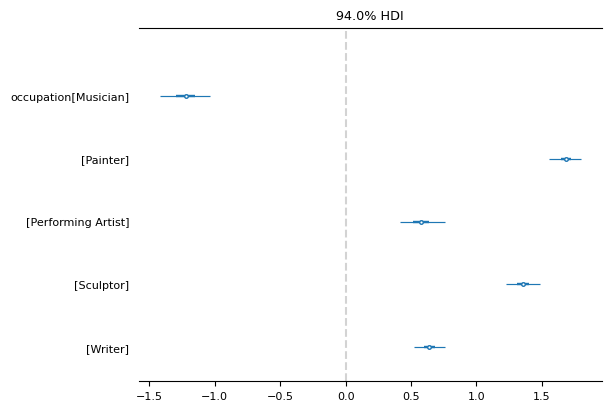

In [16]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

az.plot_forest(
    data=base_model_fitted,
    var_names=["occupation"],
    r_hat=False,
    combined=True,
    textsize=8,
    ess=False,
    ax=ax
)

# fig = forest_plot[0].get_figure()
# fig.set_size_inches(8, 4)  # Adjust size as needed
# fig.tight_layout()
# fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

plt.axvline(0, c='lightgrey', ls='--')
#fig.savefig("results/occupation/forest_plot.png")

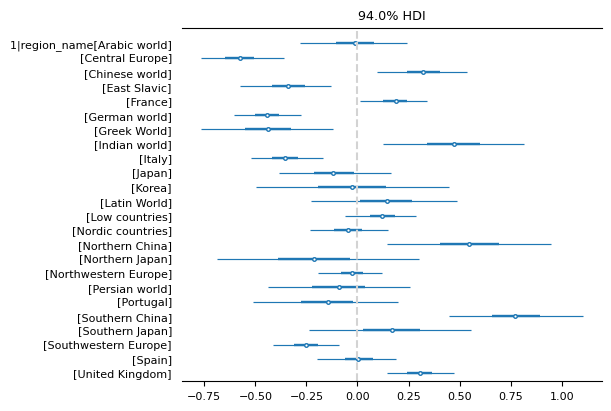

In [17]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

az.plot_forest(
    data=base_model_fitted,
    var_names=["1|region_name"],
    r_hat=False,
    combined=True,
    textsize=8,
    ess=False,
    ax=ax
)

# fig = forest_plot[0].get_figure()
# fig.set_size_inches(8, 4)  # Adjust size as needed
# fig.tight_layout()
# fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

plt.axvline(0, c='lightgrey', ls='--')
#fig.savefig("results/occupation/forest_plot.png")

In [18]:
#region = 'France'
#occupation = 'Architecture'
new_data = {}

#data = df_m[df_m["region_name"] == region]
data = df_m.copy()
new_data["decade"] = data["decade"].values
new_data["occupation"] = data["occupation"].values
new_data["region_name"] =  data["region_name"].values

new_data = pd.DataFrame(new_data)

base_model.predict(base_model_fitted, data=new_data)
posterior_stacked = az.extract(base_model_fitted)
#p = posterior_stacked['y_mean'].values

y_hat = posterior_stacked["y_mean"].values
y_mean = y_hat.mean(axis=1)
hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

In [19]:
# Création du dataset

data['y_mean'] = y_mean
data['y_min'] = hdi_data[0]
data['y_max'] = hdi_data[1]

def compute_f0(p):
    l = (2 * p) / (1 - p)
    f0 = 1 / (l + (l**2) / 2)
    return f0

def compute_f1(y):
    if y ==0:
        return 1
    else:
        return 0

def compute_f2(y):
    if y == 1:
        return 1
    else:
        return 0

data['f0'] = data['y_mean'].apply(lambda x : compute_f0(x))
data['max_f0'] = data['y_min'].apply(lambda x : compute_f0(x))
data['min_f0'] = data['y_max'].apply(lambda x : compute_f0(x))

data['f1'] = data['y'].apply(compute_f1)
data['f2'] = data['y'].apply(compute_f2)

#data.to_csv(PATH + '/raw_results_north_south_china.csv')
data.to_csv('unseen_species_model/unseen_species_model_bayesian.csv')

In [20]:
len(data.individual_wikidata_id.unique())

109363

### Plot Summary table

### Occupation Summary

In [21]:
# data = pd.read_csv('unseen_species_model/raw_results_north_south.csv')
# print(len(set(data.individual_wikidata_id)))

In [22]:
data_unique = data[~data['region_name'].isin(north_south_regions)]
len(set(data_unique.individual_wikidata_id))

108782

In [23]:
df_works_3 = df[df['count']>2]
df_works_3 = df_works_3[~df_works_3['region_name'].isin(north_south_regions)]
df_works_3 = df_works_3.drop_duplicates(['individual_wikidata_id', 'region_name'], keep='first')
df_works_3 = df_works_3.drop_duplicates(['individual_wikidata_id', 'occupation'], keep='first')

### Group by Occupations

In [24]:
data_group_occupation = data_unique.groupby(['occupation']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum', 'f1':'sum', 'f2':'sum'}).reset_index()
data_group_occupation = data_group_occupation.drop(['min_f0', 'max_f0'], axis=1)
data_group_occupation = data_group_occupation.reset_index(drop=True)

data_group_occupation['f0'] = round(data_group_occupation['f0'])
data_group_occupation['f0'] = data_group_occupation['f0'].apply(lambda x : int(x))

df_works_3_occupation_group = df_works_3.groupby('occupation')['individual_wikidata_id'].nunique().rename('f>2').reset_index()
data_group_occupation = pd.merge(data_group_occupation, df_works_3_occupation_group, on = 'occupation')

data_group_occupation['Estimated'] = round(data_group_occupation['f0'] +  data_group_occupation['f1'] +  data_group_occupation['f2'])
data_group_occupation['Estimated'] = data_group_occupation['Estimated'].apply(lambda x : int(x))
data_group_occupation['Observed'] = data_group_occupation['f1'] + data_group_occupation['f2'] + data_group_occupation['f>2'] 

In [25]:
df['count_works_O_is_1'] = df['count_works'].copy()
df['count_works_O_is_1'][df['count_works_O_is_1']==0] = 1

In [26]:
df_all_works_ocupation = df[['individual_wikidata_id', 'occupation', 'count_works_O_is_1']].drop_duplicates()
df_all_works_ocupation = df_all_works_ocupation.groupby(('occupation'))['count_works_O_is_1'].sum().rename('n_works').reset_index()
data_group_occupation = pd.merge(data_group_occupation, df_all_works_ocupation, on = 'occupation')

data_group_occupation = data_group_occupation.set_index('occupation')
data_group_occupation.loc['total'] = data_group_occupation.sum().astype(int)

data_group_occupation['Detection ratio (Observed/Estimated)'] = data_group_occupation['Observed']/data_group_occupation['Estimated']
data_group_occupation['coverage (f1/n_works)'] = data_group_occupation['f1']/data_group_occupation['n_works']
data_group_occupation = data_group_occupation.rename(columns = {'f0':'f0 ("unseen species")', 
                                                                'Estimated':'Estimated (f0, f1, f2, f>2)', 
                                                                'Observed':'Observed (f1, f2, f>2)', 'f0':'f0 ("unseen species")'})

data_group_occupation = data_group_occupation[[
 'f1',
 'f2',
 'f>2',
 'Observed (f1, f2, f>2)',
 'f0 ("unseen species")',
 'Estimated (f0, f1, f2, f>2)',
 'Detection ratio (Observed/Estimated)',
 'n_works',
 'coverage (f1/n_works)']].copy()

data_group_occupation

,f1,f2,f>2,"Observed (f1, f2, f>2)","f0 (""unseen species"")","Estimated (f0, f1, f2, f>2)",Detection ratio (Observed/Estimated),n_works,coverage (f1/n_works)
occupation,,,,,,,,,
Architect,7366,139,315,7820,207336,214841,0.04,14327.00,0.51
Musician,14635,84,169,14888,1441702,1456421,0.01,19275.00,0.76
Painter,21466,2326,10096,33888,109516,133308,0.25,318064.00,0.07
Performing Artist,3091,113,388,3592,45791,48995,0.07,20249.00,0.15
Sculptor,6457,486,1701,8644,48283,55226,0.16,51864.00,0.12
Writer,50865,1994,5580,58439,744818,797677,0.07,333206.00,0.15
total,103880,5142,18249,127271,2597446,2706468,0.05,756985.00,0.14


In [27]:
len(df[df['count_works_O_is_1']<2])/len(df)

0.8120061382982331

In [28]:
# Get results for every region
data_group = data_unique.drop('occupation', axis=1).drop_duplicates().groupby(['region_name']).agg({'f0':'sum', 'min_f0':'sum', 'max_f0':'sum', 'f1':'sum', 'f2':'sum', 'individual_wikidata_id':'count'}).reset_index()
data_group = data_group.rename(columns={'individual_wikidata_id':'N'})

# Get the full number of unseen individuals
data_group['N_unseen'] = data_group['f0'] +  data_group['f1'] +  data_group['f2'] #count ?
data_group['N_unseen_min'] = data_group['min_f0'] +  data_group['f1'] +  data_group['f2']
data_group['N_unseen_max'] = data_group['max_f0'] +  data_group['f1'] +  data_group['f2']

df['count_works_O_is_1'] = df['count_works'].copy()
df['count_works_O_is_1'][df['count_works_O_is_1']==0] = 1

# Merge with the works
df_all_works = df.groupby(['region_name'])['count_works_O_is_1'].sum().rename('count_works').reset_index()

data_group = pd.merge(df_all_works, data_group, on = 'region_name')
data_group = data_group.rename(columns={'count_works':'count_works_all'})
data_group = pd.merge(df_count_work_model, data_group, on = 'region_name')

df_work_3_group = df_works_3.groupby(['region_name'])['individual_wikidata_id'].nunique().rename('f>2').reset_index()
data_group = pd.merge(df_work_3_group, data_group, on = 'region_name')

data_group = data_group[~data_group['region_name'].isin(north_south_regions)]
data_group = data_group.set_index('region_name')
data_group = data_group.astype(int)

# Calculate the total of each column
total_row = data_group.sum()
# Add the 'total' row to the DataFrame
data_group.loc['total'] = total_row

# Compute metrics
# data_group['completeness'] = data_group['N']/ data_group['N_unseen']
data_group['coverage (f1/n_works)'] = 1 - data_group['f1']/ data_group['count_works_all']

data_group = data_group[['N', 'f0', 'f1', 'f2','f>2','N_unseen', 'coverage (f1/n_works)', 'count_works_all', 'count_works_f1_f2','min_f0', 'max_f0', 'N_unseen_min', 'N_unseen_max']]
#data_group = data_group.T

### Publish table

In [29]:
data_group_table = data_group.drop(['N', 'min_f0', 'max_f0','N_unseen_min', 'N_unseen_max',  'count_works_f1_f2'], axis=1)
data_group_table['Estimated (f0, f1, f2, f>2)'] = data_group_table['N_unseen'] +  data_group_table['f>2']
data_group_table = data_group_table.drop('N_unseen', axis=1)
data_group_table['Observed (f1, f2, f>2)'] = data_group_table['f1'] + data_group_table['f2'] + data_group_table['f>2']
data_group_table['Detection ratio (Observed/Estimated)'] = data_group_table['Observed (f1, f2, f>2)']/data_group_table['Estimated (f0, f1, f2, f>2)']

data_group_table = data_group_table[[
 'f1',
 'f2',
 'f>2',
 'Observed (f1, f2, f>2)',
 'f0',
 'Estimated (f0, f1, f2, f>2)',
 'Detection ratio (Observed/Estimated)',
 'count_works_all',
 'coverage (f1/n_works)']].copy()

data_group_table = data_group_table.rename(columns = {'f0':'f0 ("unseen species")', 'count_works_all':'n_works'})
data_group_table

,f1,f2,f>2,"Observed (f1, f2, f>2)","f0 (""unseen species"")","Estimated (f0, f1, f2, f>2)",Detection ratio (Observed/Estimated),n_works,coverage (f1/n_works)
region_name,,,,,,,,,
Arabic world,1122,80,240,1442,10982,12424,0.12,27025,0.96
Central Europe,8295,205,781,9281,335122,344403,0.03,28838,0.71
Chinese world,1380,124,519,2023,10642,12665,0.16,52934,0.97
East Slavic,3797,122,480,4399,102486,106885,0.04,27426,0.86
France,16719,1122,3587,21428,264993,286421,0.07,128271,0.87
German world,28382,957,2872,32211,932919,965130,0.03,101410,0.72
Greek World,1045,58,112,1215,14552,15767,0.08,7226,0.86
Indian world,378,34,80,492,3465,3957,0.12,1522,0.75
Italy,13671,554,1990,16215,412531,428746,0.04,63138,0.78


## Plot model results for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

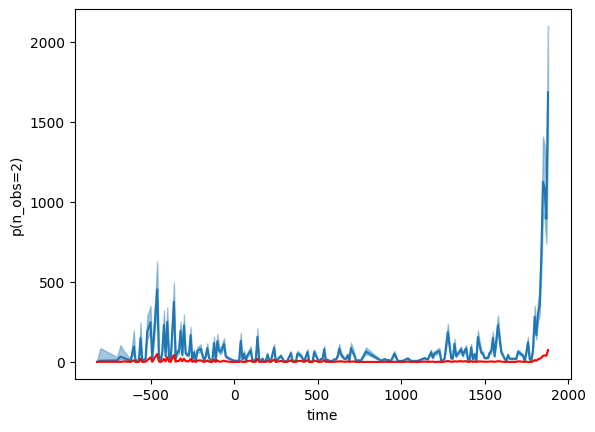

In [30]:
df_filtered = data[data['region_name'] == 'Greek World']

df_filtered = df_filtered.groupby('decade').agg({'f0':'sum', 'f1':'sum', 'f2':'sum', 'min_f0':'sum', 'max_f0':'sum'}).reset_index()
df_filtered['N'] = df_filtered['f1'] + df_filtered['f2'] 
df_filtered['N_unseen'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['f0']
df_filtered['N_unseen_min'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['min_f0']
df_filtered['N_unseen_max'] = df_filtered['f1'] + df_filtered['f2'] + df_filtered['max_f0']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(df_filtered["decade"], df_filtered['N_unseen'], color='C0')
ax.plot(df_filtered["decade"], df_filtered['N'], color='red')


# Plot credibility bands
ax.fill_between(df_filtered["decade"], df_filtered['N_unseen_min'],  df_filtered['N_unseen_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")

### Plot P(Y=2) for every region

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

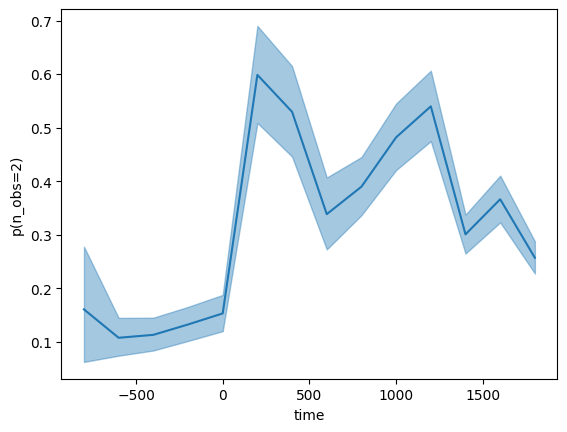

In [33]:
data_f2 = data[['region_name', 'decade', 'y_mean', 'y_min', 'y_max','occupation']].copy()
data_f2['decade'] = (data_f2['decade'] // 200 * 200).astype(int)

data_f2 = data_f2.groupby(['region_name', 'decade', 'occupation'])[['y_mean', 'y_min', 'y_max']].mean().reset_index()
data_f2 = data_f2.groupby(['region_name', 'decade'])[['y_mean', 'y_min','y_max']].sum().reset_index()

data_f2_filtered = data_f2[data_f2['region_name']=='Chinese world']

fig, ax = plt.subplots()

# Plot predicted line
ax.plot(data_f2_filtered["decade"], data_f2_filtered['y_mean'], color='C0')

# Plot credibility bands
ax.fill_between(data_f2_filtered["decade"], data_f2_filtered['y_min'],  data_f2_filtered['y_max'], alpha=0.4, color='C0')

ax.set(xlabel="time", ylabel="p(n_obs=2)")
